# Problem set 1 : Seeing in Color

#  PROBLEM 1 : color alignment

In [1]:
# setting up the environment

import numpy as np
import cv2  # if you don't have it, you can install it in anaconda prompt: pip install opencv-python
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import scipy
import scipy.ndimage
from imageio import imread, imsave
%matplotlib inline

In [2]:
np.random.seed(0)

Image size: 370 x 370


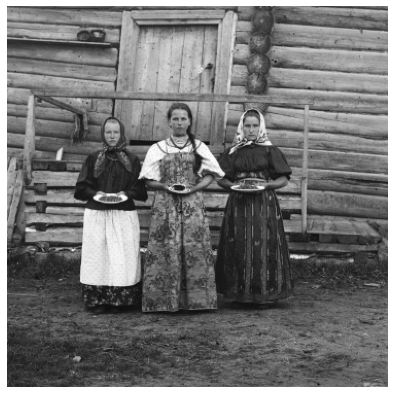

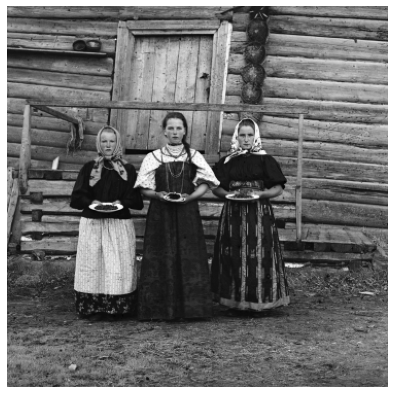

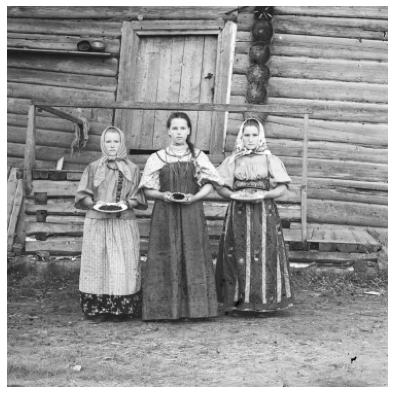

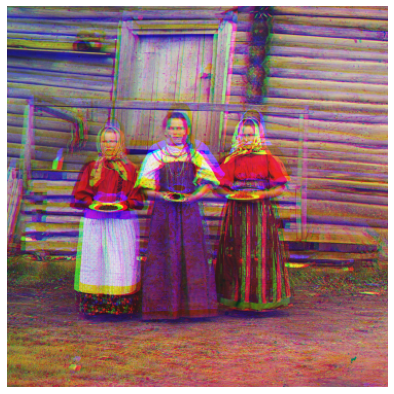

In [3]:
# reading the three color channels, and displaying them (as way as the default alignment)
red = np.array(imread('images/prokudin-girls-red.ppm',as_gray=True)/255.0)
blue = np.array(imread('images/prokudin-girls-blue.ppm',as_gray=True)/255.0)
green = np.array(imread('images/prokudin-girls-green.ppm',as_gray=True)/255.0)

print('Image size: %d x %d'% (blue.shape[0],blue.shape[1]))

# right figure size will make sure the images are displayed well, without too much aliasing or blur
plt.figure(figsize=(14,7))
plt.axis('off')
plt.imshow(blue, cmap='gray')

plt.figure(figsize=(14,7))
plt.axis('off')
plt.imshow(green, cmap='gray')

plt.figure(figsize=(14,7))
plt.axis('off')
plt.imshow(red, cmap='gray')

# now try to just superimpose the three channels; you will see significant color artifacts due to misalignment
color=np.dstack((red,green,blue))
plt.figure(figsize=(14,7))
plt.axis('off')
plt.imshow(color)

Now go ahead: implement the code for searching for the optimal alignment, and test it first on the test_image where you can introduce "synthetic" shifts, and make sure you recover from them; and then the Prokudin-Gorskii image we used above, as well as the other triplet provided (the rock image), and any additonal triplets if you would like.

## 1.1.1 Naive Stacking

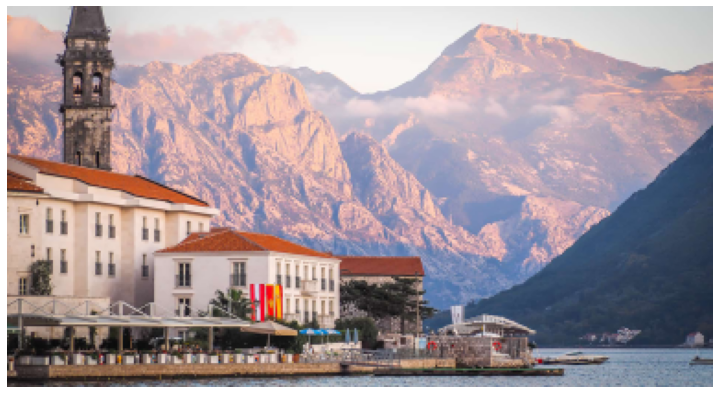

In [36]:
test = np.array(imread('images/test-image.png'))
plt.figure(figsize=(14,7))
plt.axis('off')
plt.imshow(test)

In [37]:
test_red = test[:, :, 0]
test_green = test[:, :, 1]
test_blue = test[:, :, 2]

In [101]:
def shift_channel(channel, shift_vertical, shift_horizontal):
    shifted = np.roll(channel, shift_vertical, axis=0)
    shifted = np.roll(shifted, shift_horizontal, axis=1)
    # zero-pad shifted out of bounds
    if shift_vertical > 0: # shift down
        shifted[:shift_vertical] = 0 # pad top
    elif shift_vertical < 0: # shift up
        shifted[shift_vertical:] = 0 # pad bottom
    if shift_horizontal > 0: # shift right
        shifted[:, :shift_horizontal] = 0 # pad left
    elif shift_horizontal < 0: # shift left
        shifted[:, shift_horizontal:] = 0 # pad right
    return shifted

In [102]:
SHIFT_RANGE = 15
shifts = np.random.randint(-SHIFT_RANGE, SHIFT_RANGE + 1, 4)
# green is unchanged
test_red_shifted = shift_channel(test_red, shifts[0], shifts[1])
test_blue_shifted = shift_channel(test_blue, shifts[2], shifts[3])
shifts

array([-14, -14,  -8,  -6])

In [103]:
naive = np.dstack([
    test_red_shifted, 
    test_green, 
    test_blue_shifted
])

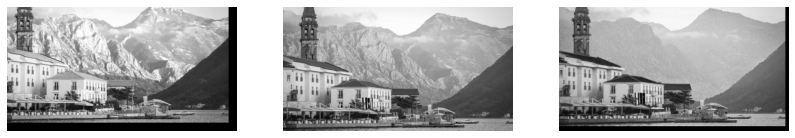

In [104]:
# side by side comparison of RGB
f, ax = plt.subplots(1, 3, figsize=(14, 7))
ax[0].imshow(test_red_shifted, cmap='gray')
ax[1].imshow(test_green, cmap='gray')
ax[2].imshow(test_blue_shifted, cmap='gray')
for a in ax:
    a.axis('off')

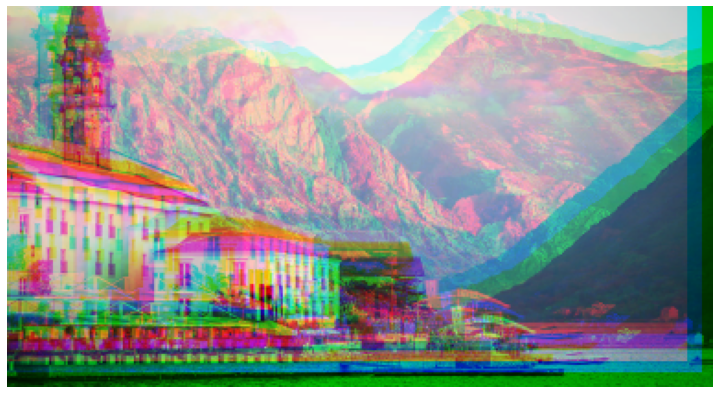

In [105]:
plt.figure(figsize=(14,7))
plt.axis('off')
plt.imshow(naive)

## 1.1.2 SSD

In [124]:
def align_channel_SSD(canonical, channel, search_range):
    best_score = np.inf # discrepancy
    ret = None
    for vert in range(-search_range, search_range + 1):
        for horiz in range(-search_range, search_range + 1):
            shifted = shift_channel(channel, vert, horiz)
            score = ((canonical - shifted) ** 2).sum()
            if score < best_score:
                best_score = score
                ret = (vert, horiz)
    return ret

In [125]:
align_channel_SSD(test_green, test_red_shifted, SHIFT_RANGE), \
align_channel_SSD(test_green, test_blue_shifted, SHIFT_RANGE)

((11, 15), (8, 6))

In [126]:
def reconstruct_SSD(red, green, blue):
    # use green as canonical
    offsets_red = align_channel_SSD(green, red, SHIFT_RANGE)
    offsets_blue = align_channel_SSD(green, blue, SHIFT_RANGE)
    aligned_red = shift_channel(red, *offsets_red)
    aligned_blue = shift_channel(blue, *offsets_blue)
    ret = np.dstack([
        aligned_red, green, aligned_blue
    ])
    return ret

In [127]:
res_SSD = reconstruct_SSD(test_red_shifted, 
                          test_green, 
                          test_blue_shifted)

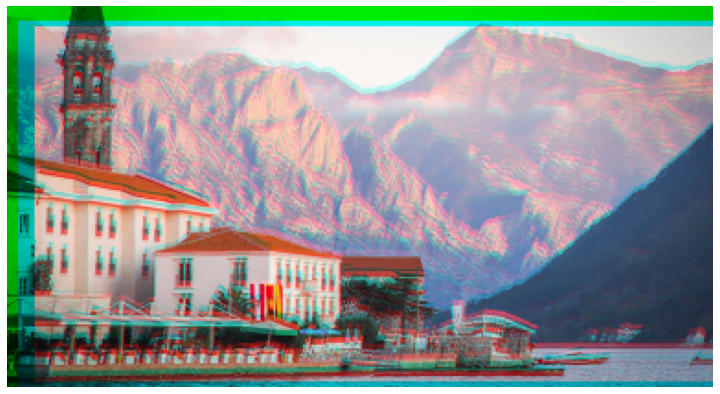

In [128]:
plt.figure(figsize=(14,7))
plt.axis('off')
plt.imshow(res_SSD)

## 1.1.3 NCC

In [157]:
def align_channel_NCC(canonical, channel, search_range):
    best_score = 0 # similarity
    ret = None
    norm_canonical = canonical / np.linalg.norm(canonical)
    for vert in range(-search_range, search_range + 1):
        for horiz in range(-search_range, search_range + 1):
            shifted = shift_channel(channel, vert, horiz)
            norm_shifted = shifted / np.linalg.norm(shifted)
            score = np.inner(norm_canonical, norm_shifted).sum()
            if score > best_score:
                best_score = score
                ret = (vert, horiz)
    return ret

In [159]:
align_channel_NCC(test_green, test_red_shifted, SHIFT_RANGE), \
align_channel_NCC(test_green, test_blue_shifted, SHIFT_RANGE)

((12, 14), (2, 0))

In [160]:
def reconstruct_NCC(red, green, blue):
    # use green as canonical
    offsets_red = align_channel_NCC(green, red, SHIFT_RANGE)
    offsets_blue = align_channel_NCC(green, blue, SHIFT_RANGE)
    aligned_red = shift_channel(red, *offsets_red)
    aligned_blue = shift_channel(blue, *offsets_blue)
    ret = np.dstack([
        aligned_red, green, aligned_blue
    ])
    return ret

In [161]:
res_NCC = reconstruct_NCC(test_red_shifted, 
                          test_green, 
                          test_blue_shifted)

In [ ]:
plt.figure(figsize=(14,7))
plt.axis('off')
plt.imshow(res_NCC)

In [ ]:
# side by side comparison
f, ax = plt.subplots(2, 2, figsize=(14, 7))
ax[0, 0].imshow(test)
ax[0, 0].title.set_text('original')
ax[0, 1].imshow(naive)
ax[0, 1].title.set_text('naive')
ax[1, 0].imshow(res_SSD)
ax[1, 0].title.set_text('SSD')
ax[1, 1].imshow(res_NCC)
ax[1, 1].title.set_text('NCC')
for a in ax.flatten():
    a.axis('off')

# PROBLEM 2: Demosaicing Bayer patterns

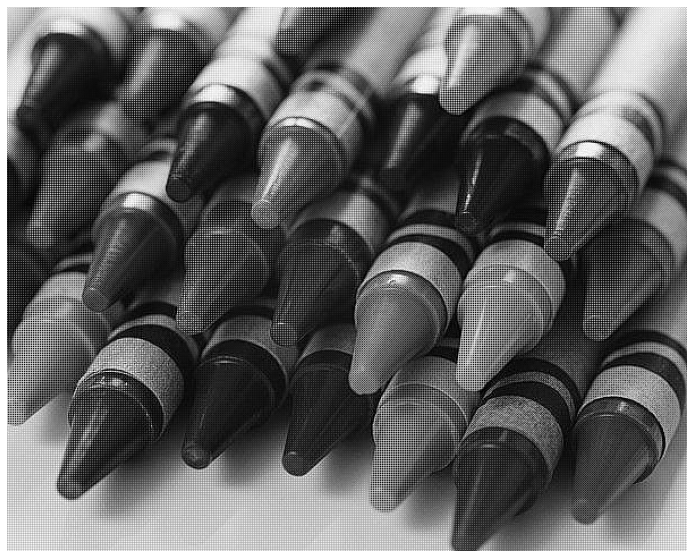

In [16]:
# we will work with this images, saved as a mosaic
# look at it first
image_path = 'images/crayons.bmp'

def read_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    return image

mosaic_img = read_image(image_path)

# Visualize the mosaic; you will notice the "checkerboard" pattern 
# (you may need to make the figure larger or smaller to see it clearly)
plt.figure(figsize=(20,10))
plt.axis('off')
plt.imshow(mosaic_img, cmap='gray')        

## Naive demosaicing

Separately interpolate each color channel

## Freeman's Method

Tie the R and B channels to G, as described; take care to scale the color values (and then un-scale them) to make sure they have the same mean across channels.